# https://www.kaggle.com/code/bhatnagardaksh/gradient-descent-from-scratch#Logistic-Regression-Model-Training

In [1]:
import warnings
warnings.filterwarnings("ignore")

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (22, 5)
plt.rcParams['figure.dpi'] = 100

import sqlite3

from sklearn.metrics import r2_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from urllib.request import urlretrieve

<h1>Data import</h1>

In [2]:
CSV_NAME = 'medical.csv'

medical_charges_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'
urlretrieve(medical_charges_url, CSV_NAME)

('medical.csv', <http.client.HTTPMessage at 0x1dc1b2aaec0>)

In [3]:
medical_df = pd.read_csv(CSV_NAME)
print(medical_df.shape)
medical_df.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<h1>Data cleaning</h1>



<h2><b>Outlier detection and removal </b></h2>


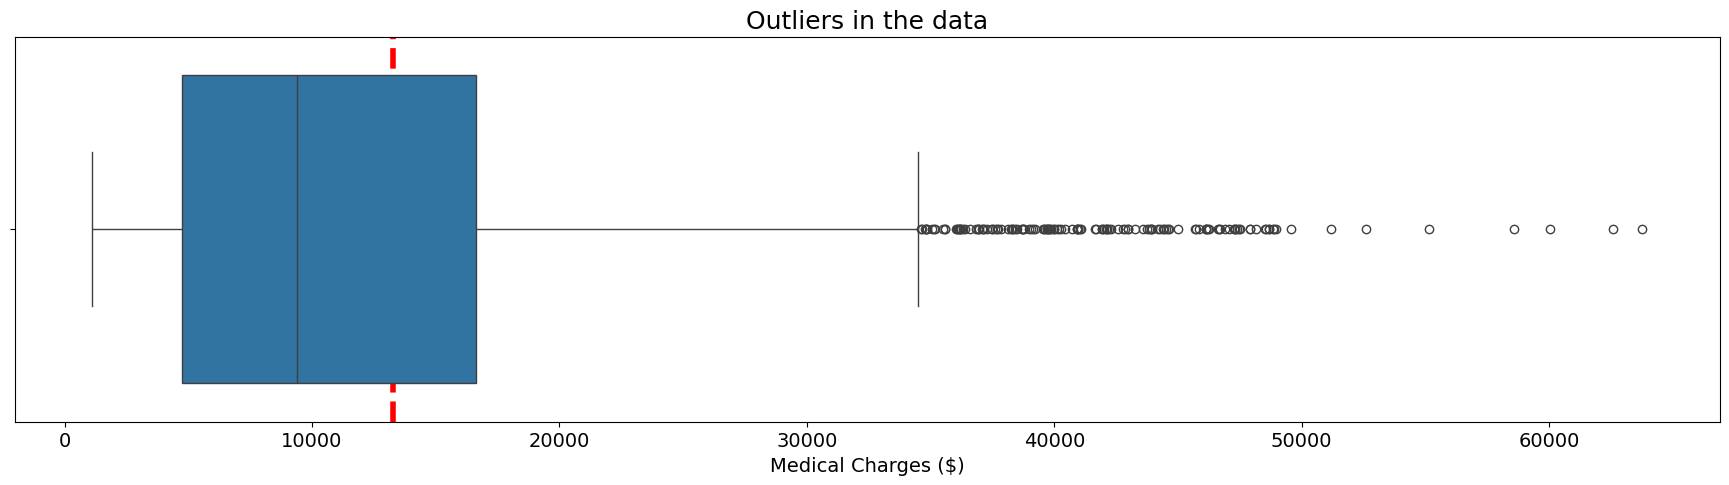

In [6]:
sns.boxplot(x=medical_df['charges'])

plt.axvline(medical_df['charges'].mean(), linestyle='--', lw=4, zorder=1, color='red')

plt.title('Outliers in the data', fontsize=18)
plt.xlabel('Medical Charges ($)')
plt.show()

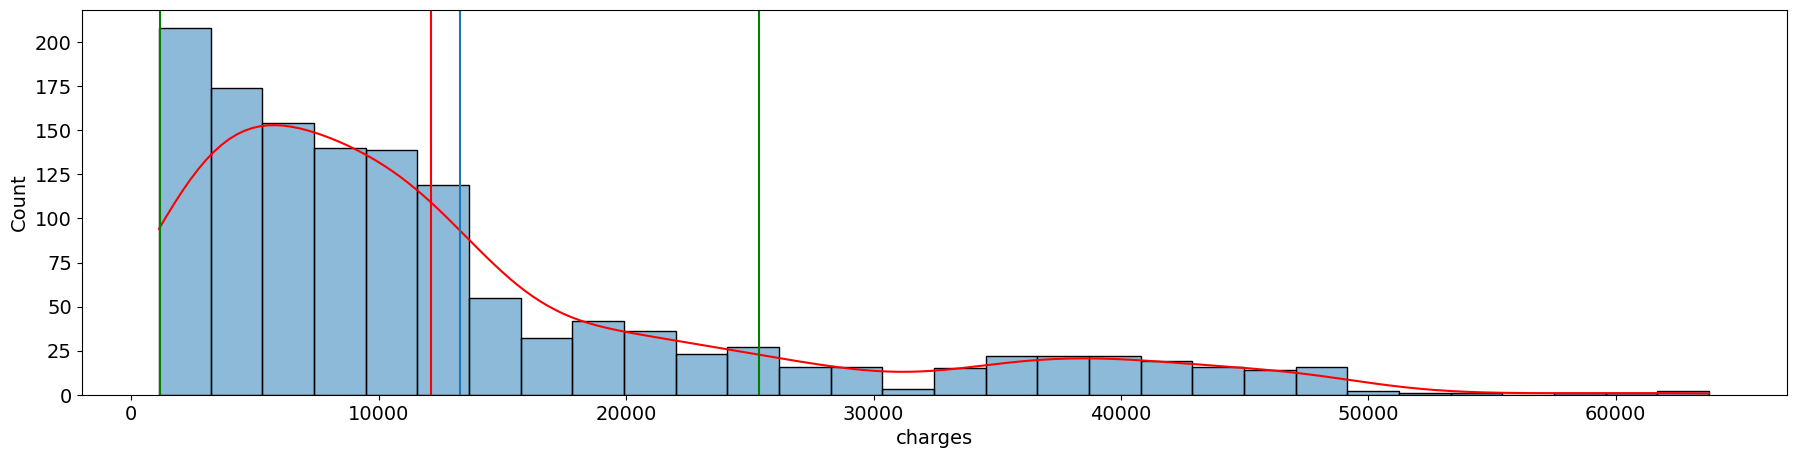

In [7]:
ax = sns.histplot(medical_df, x=medical_df['charges'], kde=True)
ax.lines[0].set_color('red')
plt.axvline(medical_df['charges'].mean())
plt.axvline(medical_df['charges'].std(), color='r')
plt.axvline(medical_df['charges'].mean() + medical_df['charges'].std(), color='g')
plt.axvline(medical_df['charges'].mean() - medical_df['charges'].std(), color='g')

Cut Off = 36316.455
Lower = -23046.033
Upper = 49586.877


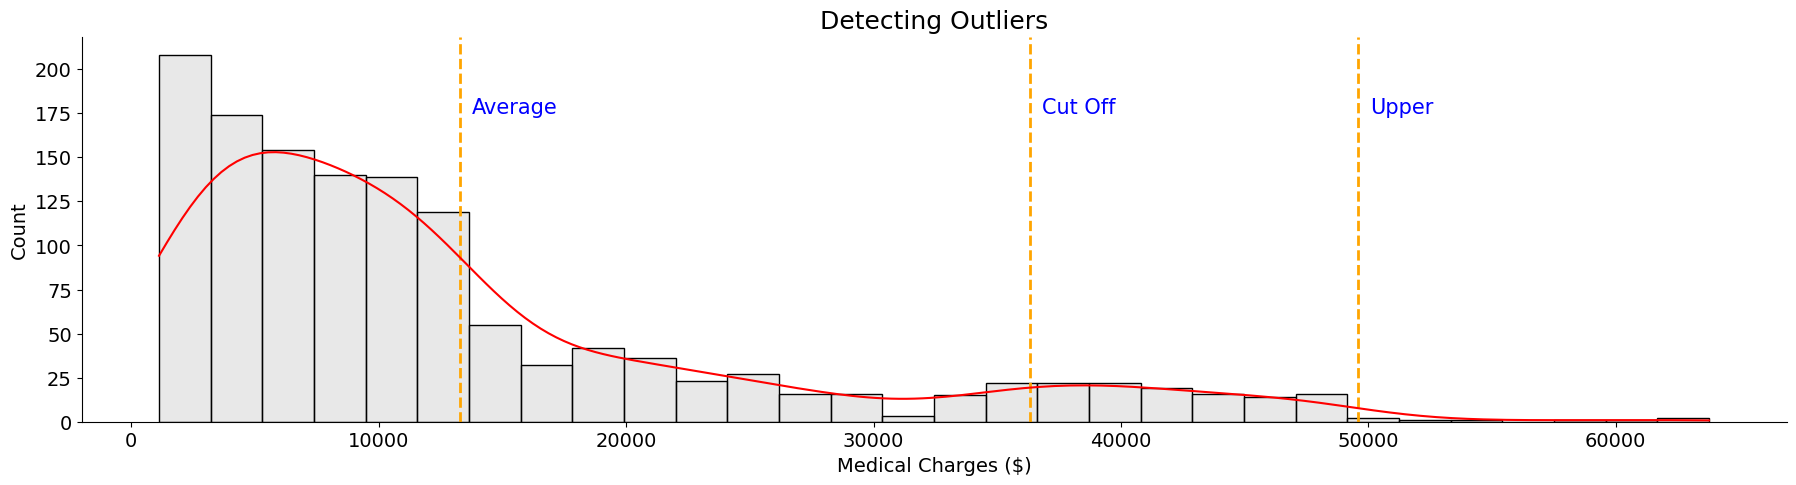

In [8]:
# Extract the 'charges' column values from the medical_df DataFrame and sort them
data = sorted(medical_df['charges'].values)

# Calculate the mean and standard deviation of the sorted 'charges' data
data_mean, data_std = np.mean(data), np.std(data)

# Calculate the cutoff value, which is three times the standard deviation
cut_off = data_std * 3

# Calculate the lower and upper bounds for identifying potential outliers
lower, upper = data_mean - cut_off, data_mean + cut_off

# Print the calculated values with appropriate labels
print('Cut Off =', round(cut_off, 3))  # Display the calculated cutoff value
print('Lower =', round(lower, 3))      # Display the calculated lower bound for potential outliers
print('Upper =', round(upper, 3))      # Display the calculated upper bound for potential outliers

ax = sns.histplot(medical_df['charges'], kde=True, color='lightgray')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);
ax.lines[0].set_color('red')
plt.axvline(data_mean, linestyle='--', lw=2, zorder=1, color='orange')
plt.annotate(f'Average', (data_mean+500, 175), fontsize=15, color='blue')

plt.axvline(upper, linestyle='--', lw=2, zorder=1, color='orange')
plt.annotate(f'Upper', (upper+500, 175), fontsize=15, color='blue')

plt.axvline(cut_off, linestyle='--', lw=2, zorder=1, color='orange')
plt.annotate(f'Cut Off', (cut_off+500, 175), fontsize=15, color='blue')

plt.title('Detecting Outliers', fontsize=18)
plt.xlabel('Medical Charges ($)')
plt.show()

In [9]:
print('The shape of our dataframe before the Outlier Removal is', medical_df.shape)
medical_df = medical_df[medical_df['charges'] < upper]
medical_df = medical_df[medical_df['charges'] > lower]
print('The shape of our dataframe after the Outlier Removal is', medical_df.shape)

The shape of our dataframe before the Outlier Removal is (1338, 7)
The shape of our dataframe after the Outlier Removal is (1331, 7)


In [10]:
df = medical_df.copy()
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<h2><b>Encoding</b></h2>


In [11]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_cols = df.select_dtypes(include='object').columns
encoder.fit(df[cat_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [12]:
onehot = encoder.transform(df[cat_cols])
encoder.categories_
print(df.shape)
print(onehot)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


(1331, 7)
[[1. 0. 0. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 1. 0.]
 ...
 [1. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 0.]]


In [13]:
encoded_cols = [['female', 'male','smokerno', 'smokeryes', 'northeast', 'northwest', 'southeast', 'southwest']]
df[['female', 'male','smokerno', 'smokeryes', 'northeast', 'northwest', 'southeast', 'southwest']] = onehot
df.drop(cat_cols, axis=1, inplace=True )
df.head()

,age,bmi,children,charges,female,male,smokerno,smokeryes,northeast,northwest,southeast,southwest
0,19,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


<h2>Scaling and normalization</h2>

In [14]:
scaler = StandardScaler()

y = df['charges'].values
X = df.drop('charges', axis=1).values

print(X.shape)
print(y.shape)

(1331, 11)
(1331,)


<h1>Building a model and training</h1>

In [15]:
# Gradient Descent Function for linear regression
def regression_gradient_descent(X_train, y_train, m, b, l2_norm=False, l1_norm=False, l2_alpha=0.0, l1_alpha=0.0):
    # Predictions using the linear equation y = mx + b
    yhat = np.dot(X_train, m) + b

    # Mean Squared Error (MSE) calculation
    MSE = (np.sum((y_train - yhat)**2)) / N
    if l2_norm:
        MSE += l2_alpha * np.sum(b**2)
    elif l1_norm:
        MSE += l1_alpha * np.sum(np.abs(b))

    # R-squared calculation to measure the goodness of fit
    r_squared = r2_score(y_train, yhat)

    # Calculate the gradient of the loss function with respect to intercept 'b'
    loss_slope_b = -(2/N) * sum(y_train - yhat)

    # Calculate the gradient of the loss function with respect to the slope 'm'
    loss_slope_m = -(2/N) * (np.dot((y_train - yhat), X_train))

    # Update the slope 'm' and intercept 'b' using the gradient descent update rule
    m = m - (learning_rate * loss_slope_m)
    b = b - (learning_rate * loss_slope_b)

    return m, b, MSE, r_squared

# Function for calculating the EarlyStopping criteria by comparing consecutive losses
def EarlyStopping(loss):
    for i in range(1, len(loss)):
        yield (loss[i-1], loss[i])

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)

(1064, 11)


In [16]:
# Set a random seed for reproducibility
np.random.seed(0)

# Calculate the total number of data points
N = X.shape[0]

# Set the initial learning rate, decay rate, and other variables
learning_rate = 0.2
ValidationLoss = []  # List to store validation loss
Trainingloss = []  # List to store training loss

# Initialize the intercept and slope
Intercept = []
Slope = []
m = np.ones(X.shape[1])  # Initializing some initial values for the slope
b = 1  # Initializing some initial values for the intercept
print('The initial Value of w and b are', m, b)

# Normalization
l1_norm = False # Lasso
l2_norm = False # Ridge
l1_alpha = 1.0
l2_alpha = 1.0

num_epochs =  2000

# Loop over multiple epochs for training
for i in range(num_epochs):
    epoch = i
    np.random.seed(0)
    np.random.shuffle([X_train_scaled, y_train])
    m, b, MSE, r_squared = regression_gradient_descent(X_train_scaled, y_train, m, b, l1_norm=True, l1_alpha=l1_alpha)
    m_test, b_test, MSE_test, r_squared_test = regression_gradient_descent(X_test_scaled, y_test, m, b, l1_norm=True, l1_alpha=l1_alpha)

    # Store values for analysis and tracking
    Intercept.append(b)
    Slope.append(m)
    Trainingloss.append(MSE)
    ValidationLoss.append(MSE_test)
    
    # Print progress every 20 epochs
    if i % 20 == 0:
        print(f'Epoch: {i}/{num_epochs} [==============================] - Loss: {MSE:.2e}; val Loss: {MSE_test:.2e}; r-squared: {round(r_squared, 4)}; val_r-squared: {round(r_squared_test, 4)}')

       
    # Early Stopping Mechanism
    for prev, curr in EarlyStopping(ValidationLoss):
        if prev - curr < 1e-6:
            print(f'\n -- Early Stopping at Epoch : {i}\n val_loss : {np.around(MSE_test, 5)},  val r-squared : {np.around(r_squared_test, 5)} --')
            break  # Inner Loop Break
    else: 
        continue  # Executed if the inner loop did NOT break
    break  # Executed if the inner loop DID break

# Print the final values of slope 'm' and intercept 'b'
print('\nThe final values of w and b are', m, b)

The initial Value of w and b are [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 1
Epoch: 0/2000 [==============================] - Loss: 2.35e+08; val Loss: 2.93e+07; r-squared: -1.2471; val_r-squared: 0.0801
Epoch: 20/2000 [==============================] - Loss: 2.68e+07; val Loss: 7.17e+06; r-squared: 0.7443; val_r-squared: 0.7753
Epoch: 40/2000 [==============================] - Loss: 2.68e+07; val Loss: 7.17e+06; r-squared: 0.7443; val_r-squared: 0.7753
Epoch: 60/2000 [==============================] - Loss: 2.68e+07; val Loss: 7.17e+06; r-squared: 0.7443; val_r-squared: 0.7753
Epoch: 80/2000 [==============================] - Loss: 2.68e+07; val Loss: 7.17e+06; r-squared: 0.7443; val_r-squared: 0.7753

 -- Early Stopping at Epoch : 87
 val_loss : 7168867.63076,  val r-squared : 0.77531 --

The final values of w and b are [ 3583.4567355   1668.34289296   764.08842482    15.5804425
   -13.5804425  -4501.51016564  4503.51016564   287.50271176
   123.54743319  -225.09978825  -168.40493046] 12779

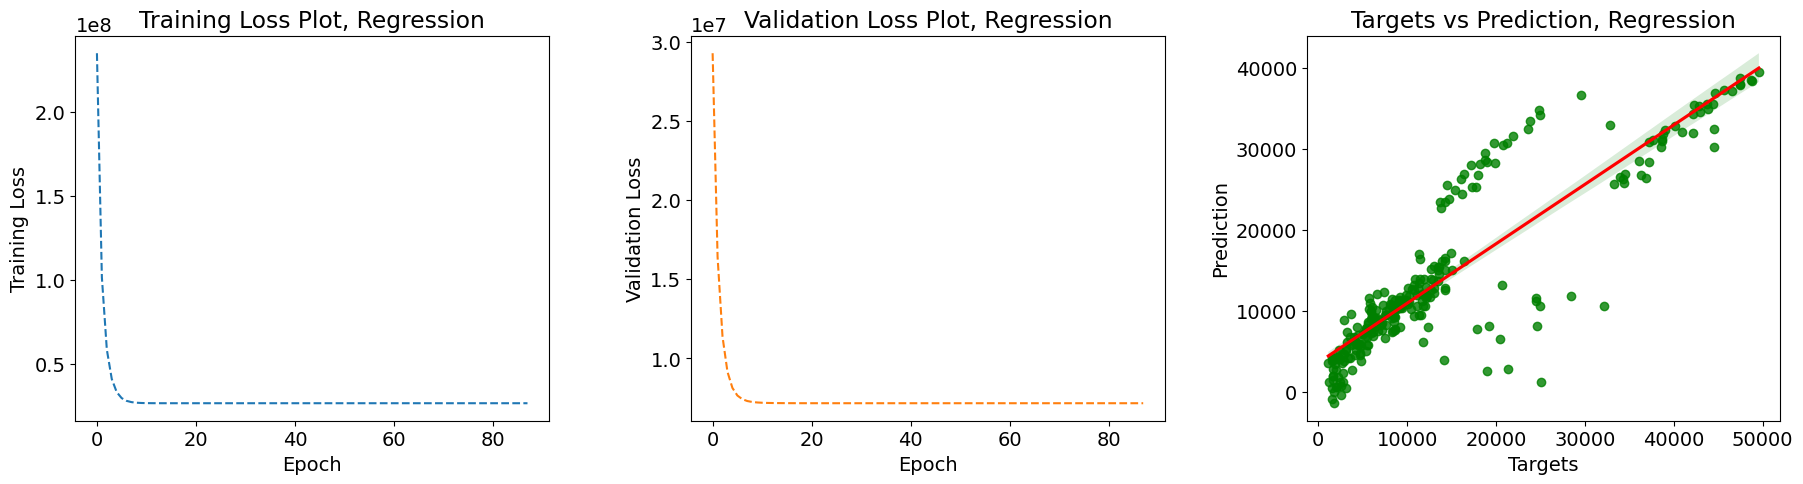

In [17]:
# Get the coefficient (slope) and intercept values for the current epoch
coefficient = Slope[epoch]
intercept = Intercept[epoch]

# Predictions using the linear regression equation y = mx + b
y_pred = np.dot(X_test_scaled, coefficient) + intercept

# Create a DataFrame to compare predicted and actual values
df = pd.DataFrame(y_pred, y_test, columns=['y']).reset_index().rename(columns={'index': 'y', 'y': 'y_pred'})

# Plotting the Figures
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5))
fig.subplots_adjust(hspace=.2, wspace=.3)

# First Plot: Training Loss Plot
ax1.plot(Trainingloss, linestyle='--')
ax1.set_title("Training Loss Plot, Regression")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')

# Second Plot: Validation Loss Plot
ax2.plot(ValidationLoss, 'tab:orange', linestyle='dashed', markersize=5)
ax2.set_title("Validation Loss Plot, Regression")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')

# Third Plot: Scatter Plot of Targets vs. Predictions
ax3 = sns.regplot(data=df, x=df['y'], y=df['y_pred'], color='green', fit_reg=True)
ax3.lines[0].set_color('red')
ax3.set_title('Targets vs Prediction, Regression')
ax3.set_xlabel('Targets')
ax3.set_ylabel('Prediction')

# Display the plots
plt.show()

<h1>Metrics</h1>

In [18]:
import math 

# MAE
mae = np.mean(np.abs(y_pred - y_test))
print("Mean absolute error : ", mae)

# MSE
mse = np.mean((y_pred - y_test)**2)
print("Mean squared error : ", mse)

# RMSE
rmse = math.sqrt(mse)
print("Root mean squared error: ", rmse)

# R2
r2 = 1 - np.sum((y_test - y_pred)**2)/np.sum((y_test - np.mean(y_test))**2)
print("R2 = ", r2)

# Adjusted R2
aR2 = 1 - ((1 - r2)*(X_train.shape[0] - 1)/(X_train.shape[0] - X_train.shape[1] - 1))
print("aR2 = ", aR2)

import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)  # Adding an intercept term
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())  # Shows adjusted R-squared and other statistical details

# Residual analysis

Mean absolute error :  4226.409712252223
Mean squared error :  35673232.896599814
Root mean squared error:  5972.707333914815
R2 =  0.7753095020968365
aR2 =  0.7729600767385334
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     383.9
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          3.92e-306
Time:                        15:46:39   Log-Likelihood:                -10727.
No. Observations:                1064   AIC:                         2.147e+04
Df Residuals:                    1055   BIC:                         2.152e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err 